#Informe Final de la Prueba Técnica 1

####**Autor:** Daniela Zabaleta Benitez
####**Fecha:** 20/08/2025
####**Descripción:** Notebook para presentar el informe detallado sobre la prueba técnica #1, donde se analizan y predicen los costos de 2 equipos a partir de los datos historicos de los precios de 3 materias primas (X, Y y Z).
####Se probó el funcionamiento del modelo SARIMAX para predecir y calcular los costos de los 2 equipos basandome en las predicciones de los precios de las materias primas.

#1. Explicación del caso
####Una empresa de construcción necesita estimar el costo de dos equipos esenciales durante un proyecto de 36 meses.
####El costo base de estos equipos se puede establecer en función del precio de tres materias primas que los componen: X, Y, Z.

*   Equipo 1 → 0.2 * X + 0.8 * Y
*   Equipo 2 → (X + Y + Z)/3

####El objetivo es generar un modelo que permita estimar los precios futuros de los equipos y así mejorar la planificación financiera y una optimización de recursos al seleccionar proveedores con mejor relación costo-beneficio.





#2. Supuestos

####El objetivo es predecir los precios de las materias primas X, Y y Z a futuro, por lo que se plantea una predicción de 3, 6, 12, 24 y 36 meses (corto, mediano y largo plazo).
####El punto de partida de las predicciones deberia ser el ultimo mes real disponible en los datos, para este caso es abril de 2024 (X es la serie más larga), por lo que se deberia tomar como mes base mayo de 2024.
####Así, los 36 meses de predicción deberian ir desde mayo 2024 hasta abril 2027.

#3. Formas de resolver el caso y la opcion elegida

####Algunas formas de resolver el caso son:


*   Usando el promedio historico (baseline) donde este se calcula para cada materia prima y se asume que ese valor ser mantiene en los proximos meses, esto sirve como punto de comparación y es facil de entender, pero no se capturan tendencias ni cambios estacionales.
*   Usando la regresión lineal ya que los datos tienen filas y rangos de tiempo distintos, pero esta asume que los datos siguen una linea recta con el tiempo y los datos entregados no muestran una tendencia lineal clara (suben y bajan, hay estacionalidad).
*   Usando un modelo SARIMAX que es clasico para las series de tiempo porque capta patrones de tendencia y estacionalidad.
*   Usando un modelo XGBoost que es un modelo de aprendizaje automatico que aprende de los valores pasados, detectando patrones no lineales y relaciones, me parece que la hiperparametrización es compleja.

####La opción elegida es el modelo SARIMAX ya que es un modelo para series temporales porque capta esos patrones estacionales de los datos lo cual es favorable para la predicción.








#4. Resultados del análisis de los datos y los modelos

###4.1 Librerias

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')

###4.2 Cagar los datos

In [ ]:
#Ruta archivos
%cd /content/drive/MyDrive/Colab Notebooks/Prueba Técnica Cientifico de Datos/Prueba tecnica 1

/content/drive/MyDrive/Colab Notebooks/Prueba Técnica Cientifico de Datos/Prueba tecnica 1


In [ ]:
df_x = pd.read_csv('Datos/X_cleaned.csv')
df_y = pd.read_csv('Datos/Y_cleaned.csv')
df_z = pd.read_csv('Datos/Z_cleaned.csv')

In [ ]:
df_x.head(5)

,Date,Price
0,2024-04-04,89.18
1,2024-04-03,89.35
2,2024-04-02,88.92
3,2024-04-01,87.42
4,2024-03-28,87.48


###4.3 Preparación de los datos

In [ ]:
#Fecha tipo datetime y orden

df_x['Date'] = pd.to_datetime(df_x['Date'])
df_x = df_x.sort_values('Date')

df_y['Date'] = pd.to_datetime(df_y['Date'])
df_y = df_y.sort_values('Date')

df_z['Date'] = pd.to_datetime(df_z['Date'])
df_z = df_z.sort_values('Date')

###4.3.1 Resampleo a frecuencia mensual
####Los datos originales vienen en distintas fechas, por lo que para comparar y combinarlos es necesario que todos esten en la misma frecuencia lo que permite una mejor planeación.

In [ ]:
x = df_x.copy()
x.set_index('Date', inplace=True)
x = x.resample('MS').mean()
x

,Price
Date,
1988-06-01,15.172500
1988-07-01,14.924286
1988-08-01,15.009091
1988-09-01,13.540909
1988-10-01,12.555238
...,...
2023-12-01,77.324000
2024-01-01,79.149545
2024-02-01,81.716190


In [ ]:
y = df_y.copy()
y.set_index('Date', inplace=True)
y = y.resample('MS').mean()
y

,Price
Date,
2006-07-01,541.000000
2006-08-01,498.913043
2006-09-01,475.714286
2006-10-01,471.704545
2006-11-01,471.363636
...,...
2023-05-01,550.593913
2023-06-01,541.775909
2023-07-01,554.357619


In [ ]:
z = df_z.copy()
z.set_index('Date', inplace=True)
z = z.resample('MS').mean()
z

,Price
Date,
2010-01-01,2233.892857
2010-02-01,2048.575000
2010-03-01,2204.130435
2010-04-01,2313.727273
2010-05-01,2048.666667
...,...
2023-04-01,2333.300000
2023-05-01,2271.586957
2023-06-01,2180.738636


###4.4 Modelo

#####**SARIMAX**
#####*p → captura la relación lineal entre la observación actual y sus valores pasados.*
#####*d → numero de diferencias que debe tomar para lograr la estacionariedad.*
#####*q → relación lineal entre la observación actual y los términos de ruido blanco pasados.*
#####*s → periodo (frecuencia) estacional (mensual, para este caso).*




####4.4.1. Modelo SARIMAX para X

In [ ]:
modelo = SARIMAX(x['Price'],
                 order=(1, 1, 1),
                 seasonal_order=(1, 1, 1, 36),
                 enforce_stationarity=False,
                 enforce_invertibility=False)

resultado = modelo.fit(disp=False)

#Predicción a futuro para 36 meses
steps = 36
predX = resultado.get_forecast(steps=steps)
pred_mean_X = predX.predicted_mean
confidence_intervals_x = predX.conf_int()

#Ultima fecha real
last_date = x.index[-1]
#Fechas futuras (MS)
fechas_futuras_x = pd.date_range(start=last_date + pd.offsets.MonthBegin(1), periods=steps, freq="MS")

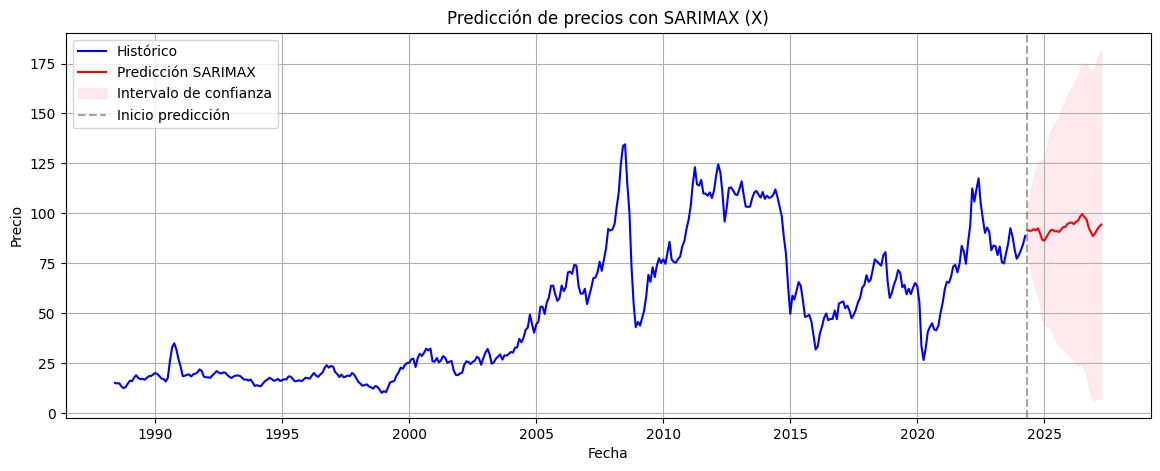

In [ ]:
#Visualización predicciones
plt.figure(figsize=(14, 5))
plt.plot(x.index, x['Price'], label='Histórico', color='blue')
plt.plot(fechas_futuras_x, pred_mean_X, label='Predicción SARIMAX', color='red')
plt.fill_between(fechas_futuras_x, confidence_intervals_x.iloc[:, 0], confidence_intervals_x.iloc[:, 1], color='pink', alpha=0.3, label='Intervalo de confianza')
plt.axvline(x=fechas_futuras_x[0], color="gray", linestyle="--", alpha=0.7, label="Inicio predicción")
plt.title('Predicción de precios con SARIMAX (X)')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend()
plt.grid(True)
plt.show()

####4.4.2 Modelo SARIMAX para Y

In [ ]:
modelo = SARIMAX(y['Price'],
                 order=(1, 1, 1),
                 seasonal_order=(1, 1, 1, 36),
                 enforce_stationarity=False,
                 enforce_invertibility=False)

resultado = modelo.fit(disp=False)

#Predicción a futuro
steps = 43
predY = resultado.get_forecast(steps=steps)
pred_mean_Y = predY.predicted_mean
confidence_intervals_y = predY.conf_int()

#Ultima fecha real
last_date = y.index[-1]
#Fechas futuras (MS)
fechas_futuras_y = pd.date_range(start=last_date + pd.offsets.MonthBegin(1), periods=steps, freq="MS")

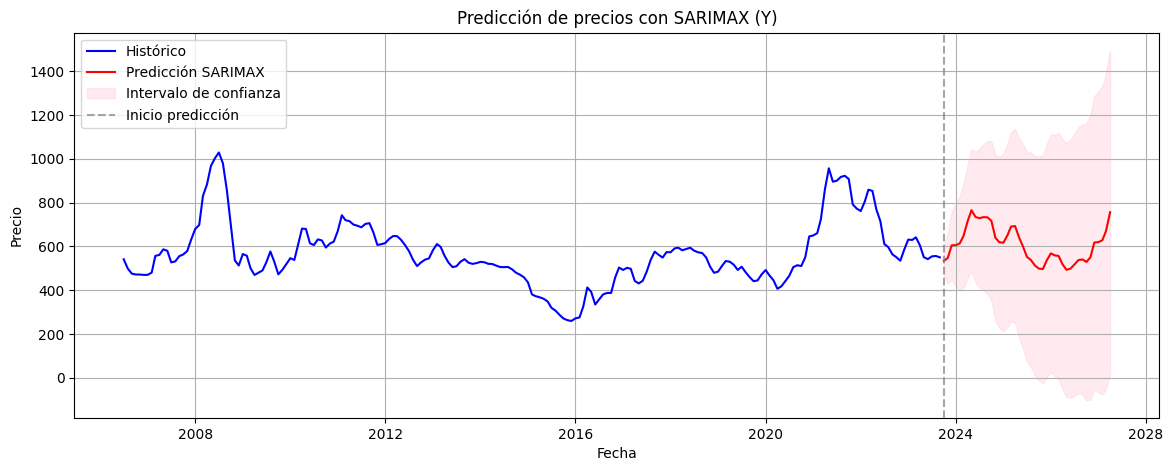

In [ ]:
#Visualización predicciones
plt.figure(figsize=(14, 5))
plt.plot(y.index, y['Price'], label='Histórico', color='blue')
plt.plot(fechas_futuras_y, pred_mean_Y, label='Predicción SARIMAX', color='red')
plt.fill_between(fechas_futuras_y, confidence_intervals_y.iloc[:, 0], confidence_intervals_y.iloc[:, 1], color='pink', alpha=0.3, label='Intervalo de confianza')
plt.axvline(x=fechas_futuras_y[0], color="gray", linestyle="--", alpha=0.7, label="Inicio predicción")
plt.title('Predicción de precios con SARIMAX (Y)')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend()
plt.grid(True)
plt.show()

####4.4.3 Modelo SARIMAX para Z

In [ ]:
modelo = SARIMAX(z['Price'],
                 order=(1, 1, 1),
                 seasonal_order=(1, 1, 1, 24),
                 enforce_stationarity=False,
                 enforce_invertibility=False)

resultado = modelo.fit(disp=False)

#Predicción a futuro
steps = 44
predZ = resultado.get_forecast(steps=steps)
pred_mean_Z = predZ.predicted_mean
confidence_intervals_z = predZ.conf_int()

#Ultima fecha real
last_date = z.index[-1]
#Fechas futuras (MS)
fechas_futuras_z = pd.date_range(start=last_date + pd.offsets.MonthBegin(1), periods=steps, freq="MS")

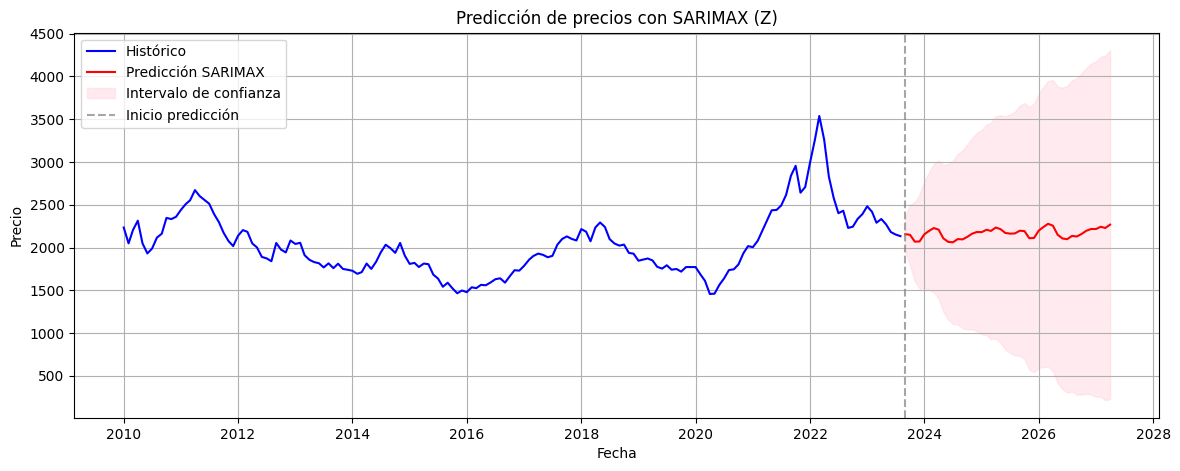

In [ ]:
#Visualización predicciones
plt.figure(figsize=(14, 5))
plt.plot(z.index, z['Price'], label='Histórico', color='blue')
plt.plot(fechas_futuras_z, pred_mean_Z, label='Predicción SARIMAX', color='red')
plt.fill_between(fechas_futuras_z, confidence_intervals_z.iloc[:, 0], confidence_intervals_z.iloc[:, 1], color='pink', alpha=0.3, label='Intervalo de confianza')
plt.axvline(x=fechas_futuras_z[0], color="gray", linestyle="--", alpha=0.7, label="Inicio predicción")
plt.title('Predicción de precios con SARIMAX (Z)')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend()
plt.grid(True)
plt.show()

###4.5 Guardar predicciones

In [ ]:
tabla_pred_X = pd.DataFrame({
    'Date': fechas_futuras_x,
    'Price X': predX.predicted_mean.values,
})

tabla_pred_Y = pd.DataFrame({
    'Date': fechas_futuras_y,
    'Price Y': predY.predicted_mean.values,
})

tabla_pred_Z = pd.DataFrame({
    'Date': fechas_futuras_z,
    'Price Z': predZ.predicted_mean.values,
})

In [ ]:
tabla_pred_X['Date'] = tabla_pred_X['Date'].dt.strftime('%Y-%m')
tabla_pred_Y['Date'] = tabla_pred_Y['Date'].dt.strftime('%Y-%m')
tabla_pred_Z['Date'] = tabla_pred_Z['Date'].dt.strftime('%Y-%m')

tabla_pred = pd.merge(tabla_pred_X, tabla_pred_Y, on='Date', how='outer')
tabla_pred = pd.merge(tabla_pred, tabla_pred_Z, on='Date', how='outer')
tabla_pred.sort_values(by='Date', inplace=True)

tabla_pred.set_index('Date', inplace=True)
tabla_pred

,Price X,Price Y,Price Z
Date,,,
2023-09,NaN,NaN,2155.263244
2023-10,NaN,533.901361,2149.375077
2023-11,NaN,547.286746,2068.761669
2023-12,NaN,605.043838,2070.567098
2024-01,NaN,605.487488,2155.299682
2024-02,NaN,613.762973,2195.223160
2024-03,NaN,647.920441,2227.668111
2024-04,NaN,714.039323,2209.111043
2024-05,91.551473,765.422966,2107.580759


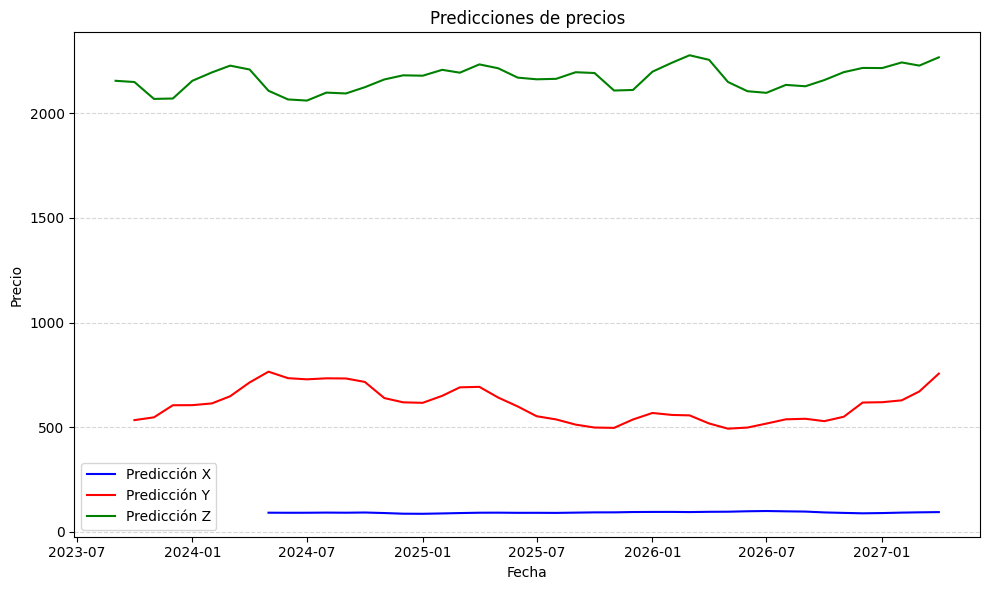

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(fechas_futuras_x, pred_mean_X, label='Predicción X', color='blue')
plt.plot(fechas_futuras_y, pred_mean_Y, label='Predicción Y', color='red')
plt.plot(fechas_futuras_z, pred_mean_Z, label='Predicción Z', color='green')

plt.title('Predicciones de precios')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

###4.6 Calculos de costos equipos

In [ ]:
tabla_pred = tabla_pred.dropna()
tabla_pred.head()

,Price X,Price Y,Price Z
Date,,,
2024-05,91.551473,765.422966,2107.580759
2024-06,91.285319,734.381507,2066.190965
2024-07,91.370215,728.837310,2060.772066
2024-08,92.113382,733.666125,2098.791470
2024-09,91.551124,732.912643,2094.772605


In [ ]:
#Calculo del costo de los equipos
tabla_pred['Equipo 1'] = 0.2 * tabla_pred['Price X'] + 0.8 * tabla_pred['Price Y']
tabla_pred['Equipo 2'] = (tabla_pred['Price X'] + tabla_pred['Price Y'] + tabla_pred['Price Z']) / 3

tabla_pred

,Price X,Price Y,Price Z,Equipo 1,Equipo 2
Date,,,,,
2024-05,91.551473,765.422966,2107.580759,630.648668,988.185066
2024-06,91.285319,734.381507,2066.190965,605.762269,963.952597
2024-07,91.370215,728.837310,2060.772066,601.343891,960.326530
2024-08,92.113382,733.666125,2098.791470,605.355577,974.856992
2024-09,91.551124,732.912643,2094.772605,604.640340,973.078791
2024-10,92.530520,716.461879,2124.590117,591.675607,977.860839
2024-11,89.986720,639.294495,2161.685001,529.432940,963.655405
2024-12,86.804446,618.917275,2181.413949,512.494709,962.378557
2025-01,86.368175,616.602730,2179.572852,510.555819,960.847919


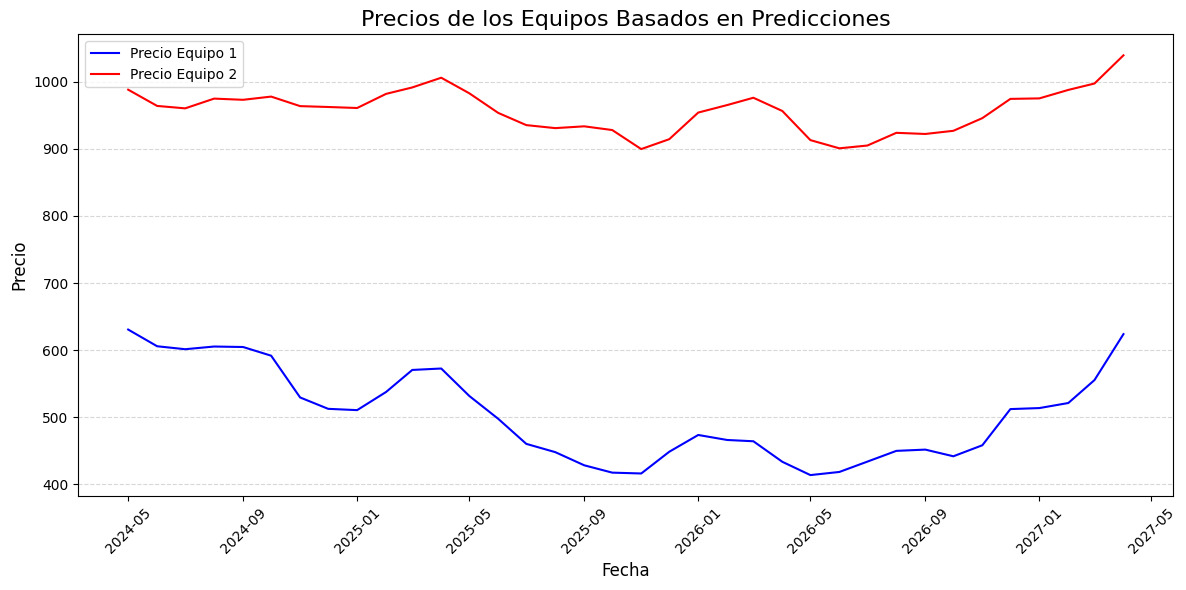

In [ ]:
tabla_pred.index = pd.to_datetime(tabla_pred.index)

plt.figure(figsize=(12, 6))

plt.plot(tabla_pred.index, tabla_pred['Equipo 1'], label='Precio Equipo 1', color='blue')
plt.plot(tabla_pred.index, tabla_pred['Equipo 2'], label='Precio Equipo 2', color='red')

plt.title('Precios de los Equipos Basados en Predicciones', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Precio', fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

#4.7 Conclusiones

####En general el equipo 1 muestra precios más volatiles (grandes cambios → picos frecuentes) y con valores bajos, el equipo 2 se mantiene en precios más estables y elevados durante la predicción.
####Ambos equipos en el tiempo presentan caidas en 2025 y una recuperación en 2027 → estacionalidad.
####Según la proyección a 36 meses se espera que los costos de ambos equipos sean iguales o superiores a los de inicio de 2024.
####Por lo que, si la empresa busca minimizar costos a corto plazo el equipo 1 es más atractivo, pero si se quiere contar con el equipo 2, el mejor momento para aquirirlo es durante mayo y septiembre de 2025.
####Estas predicciones permiten mejorar la toma de decisiones del abastacimiento y la optimización del capital del proyecto.

#5. Futuros ajustes o mejoras
####Como futuros ajustes se puede optimizar - ajustar la hiperparametrización usando algoritmos genéticos, estos imitan el proceso de selección natural trabajando con un grupo de soluciones que evolucionan con el tiempo y van mejorando el rendimiento, ya que considero que ajustar hiperparámetros es una tarea complicada.
####Tambien, se podrian probar los modelos con una frecuencia estacional diaria en lugar de mensual, asi se podrian comparar las predicciones, para ver si dan mejores resultados

#6. Apreciaciones y comentarios del caso (opcional)